# Roundtrip transfomation


## Time --> Wavelet --> Time

Let's transform a time-domain signal to wavelet-domain and back to time-domain and compare the original and reconstructed signals.


In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import chirp

from pywavelet.transforms import from_time_to_wavelet, from_wavelet_to_time
from pywavelet.transforms.types import TimeSeries, TimeAxis
import numpy as np
from typing import List


def generate_chirp_time_domain_signal(
    t: np.ndarray, freq_range: List[float]
) -> TimeSeries:
    fs = 1 / (t[1] - t[0])
    nyquist = fs / 2
    fmax = max(freq_range)
    assert (
        fmax < nyquist
    ), f"f_max [{fmax:.2f} Hz] must be less than f_nyquist [{nyquist:2f} Hz]."

    y = chirp(
        t, f0=freq_range[0], f1=freq_range[1], t1=t[-1], method="hyperbolic"
    )
    return TimeSeries(data=y, time=TimeAxis(t))


# Sizes
dt = 1 / 512
Nt = 2**6
Nf = 2**6
mult = 16
freq_range = (10, 0.2 * (1 / dt))
ND = Nt * Nf

# time grid
ts = np.arange(0, ND) * dt
Tobs = max(ts)
fs = np.arange(0, ND // 2 + 1) * 1 / (Tobs)
h_time = generate_chirp_time_domain_signal(ts, freq_range)

# transform to wavelet domain
h_wavelet = from_time_to_wavelet(h_time, Nf=Nf, Nt=Nt, mult=mult)

# transform back to time domain
h_reconstructed = from_wavelet_to_time(h_wavelet, dt=h_time.dt, mult=mult)

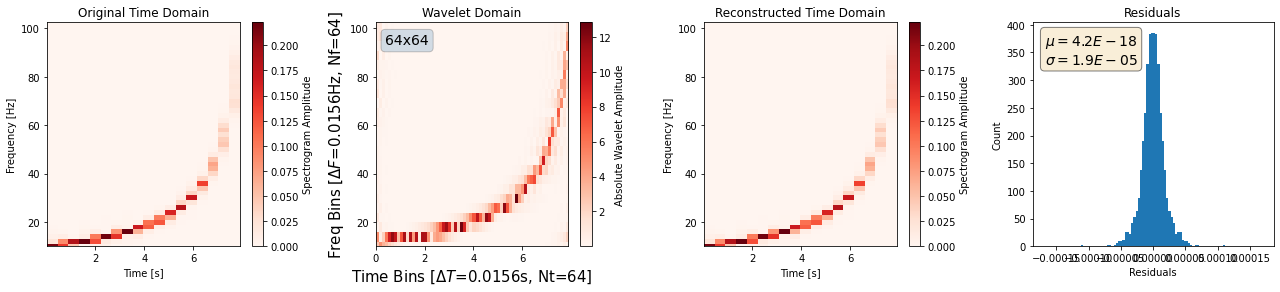

In [14]:
def plot_residuals(ax, residuals):
    ax.hist(residuals, bins=100)
    # add textbox of mean and std
    mean = residuals.mean()
    std = residuals.std()
    textstr = f"$\mu={mean:.1E}$\n$\sigma={std:.1E}$"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    ax.text(
        0.05,
        0.95,
        textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=props,
    )
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Count")
    return ax


fig, axes = plt.subplots(1, 4, figsize=(18, 4))
_ = h_time.plot_spectrogram(ax=axes[0])
_ = h_wavelet.plot(ax=axes[1], absolute=True, cmap="Reds")
_ = h_reconstructed.plot_spectrogram(ax=axes[2])
_ = plot_residuals(axes[3], h_time.data - h_reconstructed.data)
axes[0].set_title("Original Time Domain")
axes[1].set_title("Wavelet Domain")
axes[2].set_title("Reconstructed Time Domain")
axes[3].set_title("Residuals")
for ax in axes[0:3]:
    ax.set_ylim(*freq_range)
fig.show()